In [1]:
from wobble.interp import interp
import h5py
import wobble
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


NotFoundError: dlopen(/usr/local/lib/python2.7/site-packages/wobble-0.0.0-py2.7-macosx-10.10-x86_64.egg/wobble/interp/interp_op.so, 6): no suitable image found.  Did find:
	/usr/local/lib/python2.7/site-packages/wobble-0.0.0-py2.7-macosx-10.10-x86_64.egg/wobble/interp/interp_op.so: stat() failed with errno=20

In [ ]:
starid = 'hip54287'
filename = '../data/'+starid+'_e2ds.hdf5'

In [ ]:
with h5py.File(filename) as f:
    data = np.log(f['data'][30])
    data_xs = np.log(f['xs'][30])
    ivars = np.copy(f['ivars'][30])
    pipeline_rvs = -1. * np.copy(f['pipeline_rvs'])
    bervs = np.copy(f['bervs']) * -1.e3
    airms = np.copy(f['airms'])

In [ ]:
for n in range(len(data)):
    data[n] -= wobble.fit_continuum(data_xs[n], data[n], ivars[n])

In [ ]:
plt.plot(data_xs[0], data[0])
plt.plot(data_xs[5], data[5])

In [ ]:
len(data)

In [2]:
a = wobble.star(starid+'_e2ds.hdf5', orders=[30])
a.initialize_model(0, 'star')
star_model_xs, star_model_ys = a.model_xs_star[0], a.model_ys_star[0]
a.initialize_model(0, 't')
t_model_xs, t_model_ys = a.model_xs_t[0], a.model_ys_t[0]

NameError: name 'wobble' is not defined

In [8]:
np.shape(star_model_xs)

(6815,)

In [9]:
import tensorflow as tf

In [10]:
T = tf.float64
star_model_xs_tensor = tf.constant(star_model_xs, dtype=T)
star_model_ys_tensor = tf.Variable(star_model_ys, dtype=T)
t_model_xs_tensor = tf.constant(t_model_xs, dtype=T)
t_model_ys_tensor = tf.Variable(t_model_ys, dtype=T)
data_tensor = tf.constant(data, dtype=T)
xs_tensor = tf.constant(data_xs, dtype=T)
ivars_tensor = tf.constant(ivars, dtype=T)

In [11]:
starting_rvs = pipeline_rvs + np.random.normal(0., 100., len(pipeline_rvs))
star_rvs_tensor = tf.Variable(starting_rvs, dtype=T)
t_rvs_tensor = tf.Variable(np.zeros_like(starting_rvs), dtype=T)

In [12]:
c = 2.99792458e8   # m/s

def doppler(v):
    frac = (1. - v/c) / (1. + v/c)
    return tf.sqrt(frac)

In [ ]:
nll = tf.constant(0.0, dtype=T)
for n in range(len(data)):
    shifted_xs_star = xs_tensor[n] + tf.log(doppler(star_rvs_tensor[n]))
    star_model = interp(shifted_xs_star, star_model_xs_tensor, star_model_ys_tensor)
    shifted_xs_t = xs_tensor[n] + tf.log(doppler(t_rvs_tensor[n]))
    t_model = interp(shifted_xs_t, t_model_xs_tensor, t_model_ys_tensor)
    model = star_model + t_model
    nll += 0.5*tf.reduce_sum((data_tensor[n] - model)**2 * ivars_tensor[n])
    
grad_model_star = tf.gradients(nll, [star_model_ys_tensor])[0] + tf.zeros_like(star_model_ys_tensor)
grad_rvs_star = tf.gradients(nll, [star_rvs_tensor])[0] + tf.zeros_like(star_rvs_tensor)
grad_model_t = tf.gradients(nll, [t_model_ys_tensor])[0] + tf.zeros_like(t_model_ys_tensor)
grad_rvs_t = tf.gradients(nll, [t_rvs_tensor])[0] + tf.zeros_like(t_rvs_tensor)

In [ ]:
opt_model_star = tf.train.AdagradOptimizer(0.01).minimize(nll, var_list=star_model_ys_tensor)
opt_rvs_star = tf.train.AdagradOptimizer(10.).minimize(nll, var_list=star_rvs_tensor)
opt_model_t = tf.train.AdagradOptimizer(0.01).minimize(nll, var_list=t_model_ys_tensor)
opt_rvs_t = tf.train.AdagradOptimizer(10.).minimize(nll, var_list=t_rvs_tensor)

In [ ]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    nll_history = []
    for i in range(100):
        session.run(opt_rvs_star)
        nll_history.append(session.run(nll))
        #if (i % 10) == 0:
        #    print "iter {0}: optimizing star RVs".format(i)
        #    print "nll: {0:.2e}".format(nll_history[-1])
        session.run(opt_rvs_t)
        nll_history.append(session.run(nll))
        #if (i % 10) == 0:
        #    print "iter {0}: optimizing telluric RVs".format(i)
        #    print "nll: {0:.2e}".format(nll_history[-1])            
        session.run(opt_model_star)
        nll_history.append(session.run(nll)) 
        #if (i % 10) == 0:
        #    print "iter {0}: optimizing star model".format(i)
        #    print "nll: {0:.2e}".format(nll_history[-1])
        session.run(opt_model_t)
        nll_history.append(session.run(nll)) 
        if (i % 10) == 0:
        #    print "iter {0}: optimizing telluric model".format(i)
            print "nll: {0:.2e}".format(nll_history[-1])

            
    #hess_result = session.run(hess)
    params_model_star = session.run(star_model_ys_tensor)
    params_rvs_star = session.run(star_rvs_tensor)
    params_model_t = session.run(t_model_ys_tensor)
    params_rvs_t = session.run(t_rvs_tensor)

In [ ]:
plt.scatter(np.arange(len(nll_history)), nll_history)
ax = plt.gca()
ax.set_yscale('log')

In [ ]:
plt.step(np.exp(star_model_xs), params_model_star, color='k')
plt.step(np.exp(t_model_xs), params_model_t, color='r')

In [ ]:
plt.scatter(pipeline_rvs, starting_rvs - pipeline_rvs)
plt.scatter(pipeline_rvs, params_rvs_star - pipeline_rvs)

In [ ]:
np.std(params_rvs_star - pipeline_rvs)

In [ ]:
np.std(pipeline_rvs - a.bervs)

In [ ]:
plt.scatter(pipeline_rvs, params_rvs_t)

In [ ]:
opt_models = tf.train.AdagradOptimizer(0.01).minimize(nll, var_list=(star_model_ys_tensor, t_model_ys_tensor))
opt_rvs = tf.train.AdagradOptimizer(10.).minimize(nll, var_list=(star_rvs_tensor, t_rvs_tensor))

In [ ]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    nll_history = []
    for i in range(100):
        session.run(opt_rvs)
        nll_history.append(session.run(nll))
        if (i % 10) == 0:
            print "iter {0}: optimizing RVs".format(i)
            print "nll: {0:.2e}".format(nll_history[-1])
        session.run(opt_models)
        nll_history.append(session.run(nll))
        if (i % 10) == 0:
            print "iter {0}: optimizing models".format(i)
            print "nll: {0:.2e}".format(nll_history[-1])            


            
    #hess_result = session.run(hess)
    params_model_star = session.run(star_model_ys_tensor)
    params_rvs_star = session.run(star_rvs_tensor)
    params_model_t = session.run(t_model_ys_tensor)
    params_rvs_t = session.run(t_rvs_tensor)

In [ ]:
plt.scatter(pipeline_rvs, starting_rvs - pipeline_rvs)
plt.scatter(pipeline_rvs, params_rvs_star - pipeline_rvs)

In [13]:
model_xs_tensor = [tf.constant(model, dtype=T) for model in [star_model_xs, t_model_xs]]
model_ys_tensor = [tf.Variable(model, dtype=T) for model in [star_model_ys, t_model_ys]]
rvs_tensor = [tf.Variable(rvs, dtype=T) for rvs in [starting_rvs, np.zeros_like(starting_rvs)]]

nll = tf.constant(0.0, dtype=T)
for n in range(len(data)):
    for c in []
    shifted_xs_star = xs_tensor[n] + tf.log(doppler(rvs_tensor[0][n]))
    star_model = interp(shifted_xs_star, model_xs_tensor[0], model_ys_tensor[0])
    shifted_xs_t = xs_tensor[n] + tf.log(doppler(rvs_tensor[1][n]))
    t_model = interp(shifted_xs_t, model_xs_tensor[1], model_ys_tensor[1])
    model = star_model + t_model
    nll += 0.5*tf.reduce_sum((data_tensor[n] - model)**2 * ivars_tensor[n])

In [14]:
grad_model = tf.gradients(nll, model_ys_tensor)
grad_rvs = tf.gradients(nll, rvs_tensor)

In [15]:
opt_models = tf.train.AdagradOptimizer(0.01).minimize(nll, var_list=model_ys_tensor)
opt_rvs = tf.train.AdagradOptimizer(10.).minimize(nll, var_list=rvs_tensor)

In [16]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    nll_history = []
    for i in range(100):
        session.run(opt_rvs)
        nll_history.append(session.run(nll))
        if (i % 10) == 0:
            print "iter {0}: optimizing RVs".format(i)
            print "nll: {0:.2e}".format(nll_history[-1])
        session.run(opt_models)
        nll_history.append(session.run(nll))
        if (i % 10) == 0:
            print "iter {0}: optimizing models".format(i)
            print "nll: {0:.2e}".format(nll_history[-1])            


    params_model = session.run(model_ys_tensor)
    params_rvs = session.run(rvs_tensor)

iter 0: optimizing RVs
nll: 5.77e+05
iter 0: optimizing models
nll: 1.09e+06
iter 10: optimizing RVs
nll: 4.62e+05
iter 10: optimizing models
nll: 4.57e+05
iter 20: optimizing RVs
nll: 4.20e+05
iter 20: optimizing models
nll: 4.19e+05
iter 30: optimizing RVs
nll: 4.02e+05
iter 30: optimizing models
nll: 4.02e+05
iter 40: optimizing RVs
nll: 3.91e+05
iter 40: optimizing models
nll: 3.91e+05
iter 50: optimizing RVs
nll: 3.83e+05
iter 50: optimizing models
nll: 3.83e+05
iter 60: optimizing RVs
nll: 3.77e+05
iter 60: optimizing models
nll: 3.77e+05
iter 70: optimizing RVs
nll: 3.73e+05
iter 70: optimizing models
nll: 3.72e+05
iter 80: optimizing RVs
nll: 3.69e+05
iter 80: optimizing models
nll: 3.69e+05
iter 90: optimizing RVs
nll: 3.66e+05
iter 90: optimizing models
nll: 3.66e+05


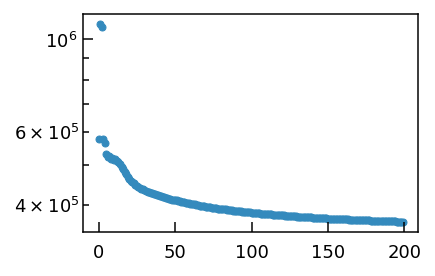

In [17]:
plt.scatter(np.arange(len(nll_history)), nll_history)
ax = plt.gca()
ax.set_yscale('log')

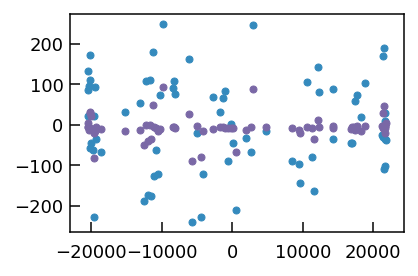

In [19]:
plt.scatter(pipeline_rvs, starting_rvs - pipeline_rvs)
plt.scatter(pipeline_rvs, params_rvs[0] - pipeline_rvs)

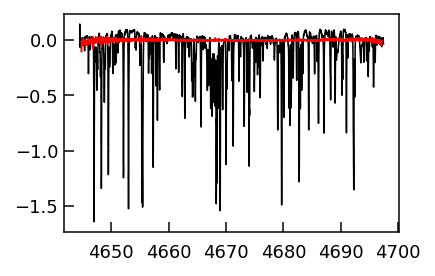

In [21]:
plt.step(np.exp(star_model_xs), params_model[0], color='k')
plt.step(np.exp(t_model_xs), params_model[1], color='r')